In [4]:
import xarray as xr
import healpy as hp
import easygems.healpix as egh
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import easygems.healpix as egh
import osmnx as ox
from shapely.geometry import mapping
from cartopy.feature import ShapelyFeature
import intake
from easygems import healpix as egh
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import geopandas as gpd
from shapely.geometry import MultiPolygon
from geopy.distance import geodesic
import numpy as np
from shapely.geometry import Point, Polygon, MultiPolygon
import geopandas as gpd
from geopy.distance import geodesic

In [5]:
zoom = '10'
# UM
file = '/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z' + zoom + '.zarr'
# ICON
#file = '/g/data/qx55/germany_node/d3hp003.zarr/PT1H_point_z11_atm.zarr'



ds = xr.open_zarr(file)
ds = ds.pipe(egh.attach_coords)
ds

<xarray.Dataset> Size: 13TB
Dimensions:  (time: 10489, cell: 12582912)
Coordinates:
  * time     (time) datetime64[ns] 84kB 2020-01-20 ... 2021-04-01
    crs      int64 8B 0
  * cell     (cell) int64 101MB 0 1 2 3 ... 12582908 12582909 12582910 12582911
    lat      (cell) float64 101MB 0.0373 0.0746 0.0746 ... -0.0746 -0.0373
    lon      (cell) float64 101MB 45.0 45.04 44.96 45.0 ... 315.0 315.0 315.0
Data variables: (12/26)
    clivi    (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    clt      (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    clwvi    (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    hflsd    (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    hfssd    (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    huss     (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    ...       ...
    rsutcs   (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    sftlf    (cell) float64 101MB dask.array<chunksize=(98304,), meta=np.ndarray>
    tas      (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    ts       (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    uas      (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    vas      (time, cell) float32 528GB dask.array<chunksize=(1, 1048576), meta=np.ndarray>

/jobfs/140911504.gadi-pbs/ipykernel_743527/3474143905.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = cities_gdf.geometry.centroid
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing with an out-of-order index is generating 328 times more chunks
  return self.array[key]


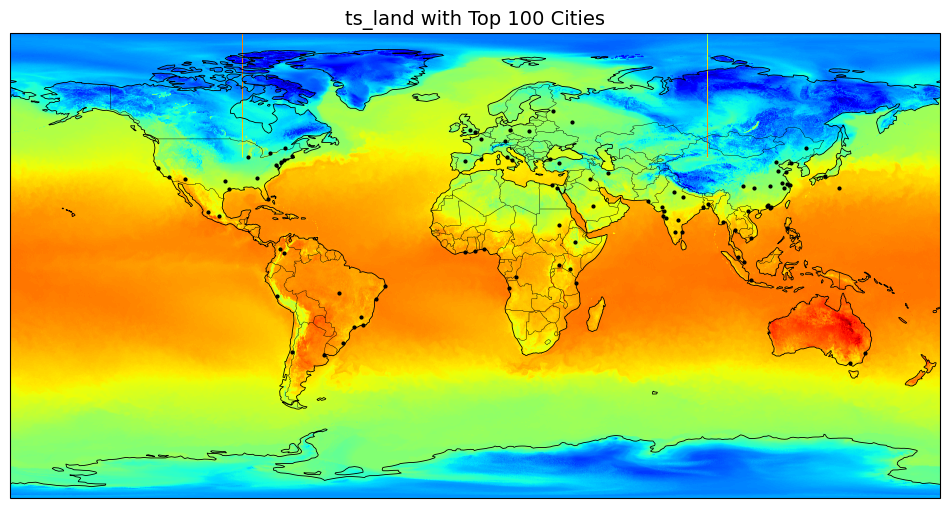

In [6]:
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.feature import ShapelyFeature
import matplotlib.pyplot as plt
import numpy as np

# Load top 100 city boundaries from file
cities_gdf = gpd.read_file("top_100_cities_boundaries.gpkg")

# Compute centroids (to represent city positions)
centroids = cities_gdf.geometry.centroid
lats = centroids.y.values
lons = centroids.x.values
names = cities_gdf['name'].values if 'name' in cities_gdf.columns else [f"City{i}" for i in range(len(cities_gdf))]

# Define the projection
projection = ccrs.PlateCarree()

# Create the figure and axis with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': projection})

# Set a global or region-specific extent
ax.set_global()  # or e.g. ax.set_extent([0, 180, -60, 60], crs=ccrs.PlateCarree())

# Add geographical features
ax.add_feature(cf.COASTLINE, linewidth=0.6)
ax.add_feature(cf.BORDERS, linewidth=0.3)
ax.add_feature(cf.LAND, facecolor='lightgray')
ax.add_feature(cf.OCEAN, facecolor='lightblue')

ts_land = ds['ts'].isel(time=0)

# Plot the HEALPix data on the Cartopy axis
egh.healpix_show(ts_land, ax=ax, cmap='jet')

# Plot each city location
for name, lat, lon in zip(names, lats, lons):
    ax.plot(lon, lat, marker='o', color='black', markersize=2, transform=ccrs.PlateCarree())
    # Uncomment to show city names
    # ax.text(lon + 1, lat + 1, name, fontsize=6, transform=ccrs.PlateCarree())

# Add title
plt.title("ts_land with Top 100 Cities", fontsize=14)

# Show the plot
plt.show()


In [7]:
# Define a function to extract the data for cities

def extract(city_name,time_start,time_end,csv_e, ds_file):

    # UM
    #file = '/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z' + zoom + '.zarr'
    # ICON
    #file = '/g/data/qx55/germany_node/d3hp003.zarr/PT1H_point_z11_atm.zarr'
    ds = xr.open_zarr(ds_file)
    print(ds_file)
    ds = ds.pipe(egh.attach_coords)
        
    # --- Load the top 100 cities GeoPackage ---
    cities_gdf = gpd.read_file("top_100_cities_boundaries.gpkg")


    
    # --- Input your city name (must match the 'city_name' column) ---
    # city_name = "Beijing, China"
    
    # --- Find the matching city ---
    city_row = cities_gdf[cities_gdf["city"] == city_name]
    
    if city_row.empty:
        raise ValueError(f"City '{city_name}' not found in the GPKG.")
    
    # --- Extract geometry ---
    city_geom = city_row.geometry.iloc[0]
    
    # --- Handle MultiPolygon vs Polygon ---
    if isinstance(city_geom, MultiPolygon):
        largest_poly = max(city_geom.geoms, key=lambda p: p.area)
    else:
        largest_poly = city_geom
    
    # --- Get centroid ---
    centroid = largest_poly.centroid
    
    # --- Compute max distance from centroid to boundary ---
    boundary_coords = np.array(largest_poly.exterior.coords)
    distances_m = [
        geodesic((centroid.y, centroid.x), (lat, lon)).meters
        for lon, lat in boundary_coords
    ]
    radius_km = max(distances_m) / 1000
    
    
    
    
    # --- Create circle polygon ---
    def create_circle(lat, lon, radius_km, num_points=360):
        angles = np.linspace(0, 360, num_points)
        circle_lats, circle_lons = [], []
        for angle in angles:
            dest = geodesic(kilometers=radius_km).destination((lat, lon), angle)
            circle_lats.append(dest.latitude)
            circle_lons.append(dest.longitude)
                    
        return Polygon([
            (geodesic(kilometers=radius_km).destination((lat, lon), angle).longitude,
             geodesic(kilometers=radius_km).destination((lat, lon), angle).latitude)
            for angle in angles
        ])
    
    
    
    circle_polygon = create_circle(centroid.y, centroid.x, radius_km)
    
    # --- Apply land mask and get ts_land ---
    land_mask = ds['orog'] > 0
    
    
    
    # for a whole year
    
    month_count = 12
    ts_city = np.zeros(int(month_count*30*24))
    ts_outside = np.zeros(int(month_count*30*24))
    
    
    ts_land = ds['ts'].isel(time=0).where(land_mask)
    
    # --- Extract coordinates and valid land data ---
    lat_2d, lon_2d = xr.broadcast(ds['lat'], ds['lon'])  # broadcast to 2D
    valid_mask = ~np.isnan(ts_land.values)
    
    valid_lons = lon_2d.values[valid_mask]
    valid_lats = lat_2d.values[valid_mask]
    valid_vals = ts_land.values[valid_mask]
    
    # --- Convert to GeoSeries ---
    points = gpd.GeoSeries(
        [Point(lon, lat) for lon, lat in zip(valid_lons, valid_lats)],
        crs="EPSG:4326"
    )
    
    # --- Classify by geometry ---
    inside_mask = points.within(largest_poly)
    inside_circle_mask = points.within(circle_polygon)
    outside_mask = ~inside_mask
    
    
    
    # do a figure here to show sampled area for validation 
    
    # --- Step 5: Plot everything ---
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # ax.set_extent([137.5, 142.5, 33.5, 38.0], crs=ccrs.PlateCarree())
    
    ax.set_facecolor('white')
    
    # Map features
    ax.add_feature(cf.COASTLINE, linewidth=0.5)
    ax.add_feature(cf.BORDERS, linewidth=0.3)
    
    # Tokyo boundary
    city_boundary = ShapelyFeature([city_geom], ccrs.PlateCarree(),
                                     edgecolor='red', facecolor='none', linewidth=1)
    ax.add_feature(city_boundary)
    
    # Centroid + circle
    ax.plot(centroid.x, centroid.y, 'bo', markersize=5,
            transform=ccrs.PlateCarree(), label='Centroid')
    
    #ax.plot(circle_lons, circle_lats, 'k--', linewidth=1.0, label=f'{radius_km:.1f} km radius')
    ax.plot(*circle_polygon.exterior.xy, 'k--', linewidth=1.0, label=f'{radius_km:.1f} km radius')
    
    
    # Convert to GeoSeries
    points = gpd.GeoSeries(
        [Point(lon, lat) for lon, lat in zip(valid_lons, valid_lats)],
        crs="EPSG:4326"
    )
    
    points_circle_not = points[inside_circle_mask & outside_mask]
    
    points_inside = points[inside_mask]
    
    # Highlighted points outside Tokyo but inside circle
    ax.plot(points_circle_not.x, points_circle_not.y, 'k.', markersize=2, label='Land: In Circle but not City')
    
    # Highlighted points inside Tokyo
    ax.plot(points_inside.x, points_inside.y, 'g.', markersize=2, label='Land: Inside City')
    
    
    # Legend and title
    ax.legend(loc='lower right')
    plt.title(str(np.size(points_inside.x))+" Land Points Inside City and " + str(np.size(points_circle_not.x)) +" Points Outside "+ city_name + " Region")
    plt.savefig('HK/'+city_name+'.png')


    
    for i in range(ts_city.size): # plot for a whole day
        
            ts_land = ds['ts'].isel(time=i).where(land_mask)
            valid_vals = ts_land.values[valid_mask]
            
            
        
            # --- Extract ts_land data ---
            ts_inside = valid_vals[inside_mask]
            ts_circle_not = valid_vals[inside_circle_mask & outside_mask]
        
            ts_city[i] = np.nanmean(ts_inside)
            ts_outside[i] = np.nanmean(ts_circle_not)
            #print(i)
    # save the two time-series data into csv
    # Create a DataFrame where each row is a time step
    df = pd.DataFrame({
        'urban_temp': ts_city,
        'rural_temp': ts_outside
    })

    # Save to CSV
    df.to_csv('HK/'+city_name+'_'+csv_e+'.csv', index_label='time_step')

In [ ]:
# ICON pair
#csv_e = 'ICON'
#ds_file = '/g/data/qx55/germany_node/d3hp003.zarr/PT1H_point_z10_atm.zarr'

# ICON pair
#csv_e = 'UM'
#file = '/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z10.zarr' 


csv_es = np.array(['ICON','UM'])
ds_files = np.array(['/g/data/qx55/germany_node/d3hp003.zarr/PT1H_point_z10_atm.zarr', '/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z10.zarr' ])

#cities_gdf = gpd.read_file("top_100_cities_boundaries.gpkg")['city'][52:].values

cities_gdf = gpd.read_file("top_100_cities_boundaries.gpkg")['city']

# now doing it for a whole month

for j in range(np.size(cities_gdf)):
    for i in range(2):
        print(cities_gdf[j])
        extract(cities_gdf[j],0,0,csv_es[i],ds_files[i])

Houston, USA
/g/data/qx55/germany_node/d3hp003.zarr/PT1H_point_z10_atm.zarr


/jobfs/140911504.gadi-pbs/ipykernel_743527/2458257774.py:164: RuntimeWarning: Mean of empty slice
  ts_city[i] = np.nanmean(ts_inside)
/jobfs/140911504.gadi-pbs/ipykernel_743527/2458257774.py:165: RuntimeWarning: Mean of empty slice
  ts_outside[i] = np.nanmean(ts_circle_not)
/jobfs/140911504.gadi-pbs/ipykernel_743527/2458257774.py:164: RuntimeWarning: Mean of empty slice
  ts_city[i] = np.nanmean(ts_inside)
/jobfs/140911504.gadi-pbs/ipykernel_743527/2458257774.py:165: RuntimeWarning: Mean of empty slice
  ts_outside[i] = np.nanmean(ts_circle_not)
/jobfs/140911504.gadi-pbs/ipykernel_743527/2458257774.py:164: RuntimeWarning: Mean of empty slice
  ts_city[i] = np.nanmean(ts_inside)
/jobfs/140911504.gadi-pbs/ipykernel_743527/2458257774.py:165: RuntimeWarning: Mean of empty slice
  ts_outside[i] = np.nanmean(ts_circle_not)
/jobfs/140911504.gadi-pbs/ipykernel_743527/2458257774.py:164: RuntimeWarning: Mean of empty slice
  ts_city[i] = np.nanmean(ts_inside)
/jobfs/140911504.gadi-pbs/ipykerne

Houston, USA
/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z10.zarr


/jobfs/140911504.gadi-pbs/ipykernel_743527/2458257774.py:164: RuntimeWarning: Mean of empty slice
  ts_city[i] = np.nanmean(ts_inside)
/jobfs/140911504.gadi-pbs/ipykernel_743527/2458257774.py:165: RuntimeWarning: Mean of empty slice
  ts_outside[i] = np.nanmean(ts_circle_not)
/jobfs/140911504.gadi-pbs/ipykernel_743527/2458257774.py:164: RuntimeWarning: Mean of empty slice
  ts_city[i] = np.nanmean(ts_inside)
/jobfs/140911504.gadi-pbs/ipykernel_743527/2458257774.py:165: RuntimeWarning: Mean of empty slice
  ts_outside[i] = np.nanmean(ts_circle_not)
/jobfs/140911504.gadi-pbs/ipykernel_743527/2458257774.py:164: RuntimeWarning: Mean of empty slice
  ts_city[i] = np.nanmean(ts_inside)
/jobfs/140911504.gadi-pbs/ipykernel_743527/2458257774.py:165: RuntimeWarning: Mean of empty slice
  ts_outside[i] = np.nanmean(ts_circle_not)
/jobfs/140911504.gadi-pbs/ipykernel_743527/2458257774.py:164: RuntimeWarning: Mean of empty slice
  ts_city[i] = np.nanmean(ts_inside)
/jobfs/140911504.gadi-pbs/ipykerne

Dallas, USA
/g/data/qx55/germany_node/d3hp003.zarr/PT1H_point_z10_atm.zarr


/jobfs/140911504.gadi-pbs/ipykernel_743527/2458257774.py:164: RuntimeWarning: Mean of empty slice
  ts_city[i] = np.nanmean(ts_inside)
/jobfs/140911504.gadi-pbs/ipykernel_743527/2458257774.py:165: RuntimeWarning: Mean of empty slice
  ts_outside[i] = np.nanmean(ts_circle_not)
/jobfs/140911504.gadi-pbs/ipykernel_743527/2458257774.py:164: RuntimeWarning: Mean of empty slice
  ts_city[i] = np.nanmean(ts_inside)
/jobfs/140911504.gadi-pbs/ipykernel_743527/2458257774.py:165: RuntimeWarning: Mean of empty slice
  ts_outside[i] = np.nanmean(ts_circle_not)
/jobfs/140911504.gadi-pbs/ipykernel_743527/2458257774.py:164: RuntimeWarning: Mean of empty slice
  ts_city[i] = np.nanmean(ts_inside)
/jobfs/140911504.gadi-pbs/ipykernel_743527/2458257774.py:165: RuntimeWarning: Mean of empty slice
  ts_outside[i] = np.nanmean(ts_circle_not)
/jobfs/140911504.gadi-pbs/ipykernel_743527/2458257774.py:164: RuntimeWarning: Mean of empty slice
  ts_city[i] = np.nanmean(ts_inside)
/jobfs/140911504.gadi-pbs/ipykerne

Dallas, USA
/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z10.zarr


/jobfs/140911504.gadi-pbs/ipykernel_743527/2458257774.py:164: RuntimeWarning: Mean of empty slice
  ts_city[i] = np.nanmean(ts_inside)
/jobfs/140911504.gadi-pbs/ipykernel_743527/2458257774.py:165: RuntimeWarning: Mean of empty slice
  ts_outside[i] = np.nanmean(ts_circle_not)
/jobfs/140911504.gadi-pbs/ipykernel_743527/2458257774.py:164: RuntimeWarning: Mean of empty slice
  ts_city[i] = np.nanmean(ts_inside)
/jobfs/140911504.gadi-pbs/ipykernel_743527/2458257774.py:165: RuntimeWarning: Mean of empty slice
  ts_outside[i] = np.nanmean(ts_circle_not)
/jobfs/140911504.gadi-pbs/ipykernel_743527/2458257774.py:164: RuntimeWarning: Mean of empty slice
  ts_city[i] = np.nanmean(ts_inside)
/jobfs/140911504.gadi-pbs/ipykernel_743527/2458257774.py:165: RuntimeWarning: Mean of empty slice
  ts_outside[i] = np.nanmean(ts_circle_not)
/jobfs/140911504.gadi-pbs/ipykernel_743527/2458257774.py:164: RuntimeWarning: Mean of empty slice
  ts_city[i] = np.nanmean(ts_inside)
/jobfs/140911504.gadi-pbs/ipykerne

Toronto, Canada
/g/data/qx55/germany_node/d3hp003.zarr/PT1H_point_z10_atm.zarr
